# Import libraries

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Extract ohlcv data
from read_data_cmc import extract_data

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Set parameters

In [57]:
# Parameters
use_cuda = 1 # Use cuda
num_seed = 1 # Random seed
torch.manual_seed(num_seed)
if use_cuda:
    torch.cuda.manual_seed(num_seed)
N_ep = 10 # Number of episodes
ep_rec = max(1,int(N_ep/10))
test_prop = 0.2 # Proportion of data set aside for test
alpha = 0.8 # Learning rate

# Define model

In [58]:
# Model
class yggdrasil(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=10, num_layers=1):
        super(yggdrasil, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM 1
        self.lstm1 = nn.LSTMCell(input_dim, hidden_dim)
        # LSTM 2
        self.lstm2 = nn.LSTMCell(hidden_dim, hidden_dim)
        # Feedforward
        self.ff = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, ohlcv, future = 0):
        # ohlcv = num_timepoints x 5
        # outputs = (num_timepoints + future) x 5
    
        # Try to predict future steps after data end
        outputs = []
        
        # Initializations for lstm1
        h1_t = torch.zeros(1, self.hidden_dim)
        c1_t = torch.zeros(1, self.hidden_dim)
        # Initializations for lstm2
        h2_t = torch.zeros(1, self.hidden_dim)
        c2_t = torch.zeros(1, self.hidden_dim)
        if use_cuda:
            h1_t = h1_t.cuda()
            c1_t = c1_t.cuda()
            h2_t = h2_t.cuda()
            c2_t = c2_t.cuda()

        # Iterate
        for i in range(ohlcv.size(0)):
            h1_t,c1_t = self.lstm1(ohlcv[i].view(1,-1), (h1_t,c1_t))
            h2_t,c2_t = self.lstm2(h1_t, (h2_t,c2_t))
            output = self.ff(h2_t)
            outputs += [output]
            
        # Predict the future
        for i in range(future):
            h1_t,c1_t = self.lstm1(ohlcv[i], (h1_t,c1_t))
            h2_t,c2_t = self.lstm2(h1_t, (h2_t,c2_t))
            output = self.ff(h2_t)
            outputs += [output]
    
        outputs = torch.stack(outputs, 1).view(ohlcv.size(0),self.input_dim)
        return outputs

# Load Data

In [59]:
# Extract data, define model and learning settings
o,h,l,c,v,cap = extract_data()
data = np.vstack([o,h,l,c,v])
data = data.T

#data = np.sin(np.linspace(0,10*np.pi,1000).reshape(-1,1)) # Test data

data = torch.from_numpy(data).float() # Convert to tensor
if use_cuda:
    data = data.cuda()

num_data = len(data) # Number of data points
num_train = int((1-test_prop)*num_data) # Number of training data

# Train-test split
data_train = data[:num_train]
data_test = data[num_train:]

# Set up observations & targets
x_train = data_train[:-1] # Observations (won't use the last point to make a prediction)
y_train = data_train[1:]  # Targets (won't try to predict the first point)
x_test = data_test[:-1]
y_test = data_test[1:]

# Train

In [60]:
# Define model
model = yggdrasil(input_dim=x_train.size(1),hidden_dim=50,num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.LBFGS(model.parameters(), lr = alpha)
if use_cuda:
    model = model.cuda()
    criterion = criterion.cuda()
losses = []
        
# Training
t_start = time.time()
t_p1 = time.time()
for i_ep in range(N_ep):
    # For LBFGS
    def closure():
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        losses.append(loss)
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    # Time stuff
    if i_ep != 0 and i_ep % ep_rec == 0:
        t_p2 = time.time()
        print('Runtime for episodes ' + str(i_ep-ep_rec) + '-' + str(i_ep) + ': ' + str(t_p2-t_p1))
        t_p1 = t_p2
    
t_finish = time.time()
print('Total time: ' + str(t_finish-t_start) + ' s')

Runtime for episodes 0-1: 5.152529716491699
Runtime for episodes 1-2: 1.5030543804168701
Runtime for episodes 2-3: 4.716609477996826
Runtime for episodes 3-4: 6.182840347290039
Runtime for episodes 4-5: 1.0859923362731934
Runtime for episodes 5-6: 1.80977463722229
Runtime for episodes 6-7: 1.8147542476654053
Runtime for episodes 7-8: 7.359952449798584
Runtime for episodes 8-9: 3.3659305572509766
Total time: 32.99236011505127 s


# Plot

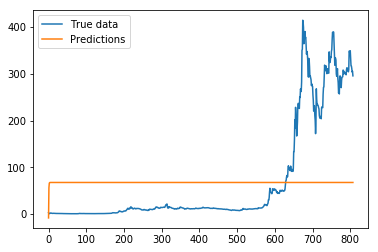

In [65]:
train_output = model(x_train)
plot_type = 1

plt.figure()
ohlcv_train = y_train.transpose(0,1)
ohlcv_train_pred = train_output.transpose(0,1)
plt.plot(ohlcv_train[plot_type],label='True data')
plt.plot(ohlcv_train_pred[plot_type].detach(),label='Predictions')

test_output = model(x_test)
plt.legend()
plt.savefig('test.png')
plt.show()

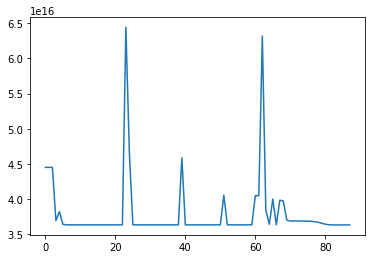

In [62]:
plt.plot(losses)
plt.show()